In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33887/status,
Dashboard: /proxy/33887/status,Workers: 8
Total threads: 8,Total memory: 22.46 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34363,Workers: 8
Dashboard: /proxy/33887/status,Total threads: 8
Started: Just now,Total memory: 22.46 GiB
Comm: tcp://127.0.0.1:44767,Total threads: 1
Dashboard: /proxy/39085/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:39565,


## Load datasets

In [26]:
# CROCO paths etc:
exp = 'PAC12_75_cpl'
expn = '02'
base = '/g/data/e14/rmh561/croco'
base_data = base + '/archive'
sim_name = 'CROCO-WRF'

os.chdir(base + '/analysis/' + exp)

In [257]:
# Load CROCO data:
data_typs = ['mon','3day','day','ts_3day']
data = {}
for typ in data_typs:
    data[typ] = xr.open_mfdataset(glob.glob(base_data + '/' + exp + '/' + exp + '_exp' + expn + '/*/croco_out_' + typ + '.nc'), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
gfiles = glob.glob(base_data + '/' + exp + '/' + exp + '_exp' + expn + '/*/croco_out_grd.nc')
data['grd'] = xr.open_dataset(gfiles[0])

Task exception was never retrieved
future: <Task finished name='Task-44874' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/client.py:2003> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/client.py", line 2008, in wait
    raise AllExit()
distributed.client.AllExit


In [258]:
# Deal with CROCO coordinates:
for d in data.values():
    try:
        d["x_rho"] = d.nav_lon_rho.isel(y_rho=0)
        d["y_rho"] = d.nav_lat_rho.isel(x_rho=0)
        d["x_w"] = d.nav_lon_rho.isel(y_rho=0)
        d["y_w"] = d.nav_lat_rho.isel(x_rho=0)
        d["x_u"] = d.nav_lon_u.isel(y_u=0)
        d["y_u"] = d.nav_lat_u.isel(x_u=0)
        d["x_v"] = d.nav_lon_v.isel(y_v=0)
        d["y_v"] = d.nav_lat_v.isel(x_v=0)
        d = d.set_coords({'x_rho','y_rho','x_u','y_u','x_v','y_v','x_w','y_w'})
    except:
        d["x_rho"] = d.nav_lon.isel(y=0)
        d["y_rho"] = d.nav_lat.isel(x=0)
        d = d.set_coords({'x_rho','y_rho'})
    
    try:
        d["z_rho"] = d.z_rho.mean('time').fillna(0.)
        d = d.set_coords({'z_rho'})
    except:
        pass

# Generate xgcm grid object:
grid = Grid(data['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

In [ ]:
# Load WRF data:
data['wrf_day'] = xr.open_mfdataset(glob.glob(base_data + '/' + exp + '/' + exp + '_exp' + expn + '/*/wrf3d_1D_*.nc'), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True).rename({'time_counter':'time'})
#data['wrf_mon'] = xr.open_mfdataset(glob.glob(base_data + '/' + exp + '/' + exp + '_exp' + expn + '/*/wrfout_*.nc'), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True).rename({'time_counter':'time'})
data['wrf_hr'] = xr.open_mfdataset(glob.glob(base_data + '/' + exp + '/' + exp + '_exp' + expn + '/*/wrf3d_1H_*.nc'), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True).rename({'time_counter':'time'})

lon = data['wrf_day'].nav_lon.isel(y=0)
lon = np.where(np.less(lon,0.).values,lon+360.,lon)
lat = data['wrf_day'].nav_lat.isel(x=0).values
data['wrf_day']["x"] = lon
data['wrf_day']["y"] = lat

In [29]:
# Set limit parameters for observations:
minyr  = data['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data['mon'].x_rho.min('x_rho').values
maxlon = data['mon'].x_rho.max('x_rho').values
minlat = data['mon'].y_rho.min('y_rho').values
maxlat = data['mon'].y_rho.max('y_rho').values

In [41]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc')
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

#OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

In [38]:
# Observational SSH:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/ua8/CMEMS_SeaLevel/v2019/' + str(yr) + '/*.nc')
CMEMS = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

CMEMS = CMEMS.sel(longitude=slice(minlon,maxlon)).sel(latitude=slice(minlat,maxlat))
CMEMS = CMEMS.rename({'longitude':'x_rho','latitude':'y_rho'})

In [39]:
# SODA reanalysis:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/e14/rmh561/croco/data/DATA/SODA342_PAC12_75/soda3.4.2_5dy_ocean_reg_' + str(yr) + '_*.nc')
SODA = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

SODA = SODA.sel(xt_ocean=slice(minlon,maxlon)).sel(yt_ocean=slice(minlat,maxlat)).sel(xu_ocean=slice(minlon,maxlon)).sel(yu_ocean=slice(minlat,maxlat))
SODA = SODA.rename({'xt_ocean':'x_rho','yt_ocean':'y_rho'})

In [40]:
# ACCESS-OM2 data:
import cosima_cookbook as cc
session = cc.database.create_session()
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('01degIAF', {'model':'ACCESS-OM2-01 IAF', 'expt':'01deg_jra55v140_iaf_cycle3', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
])

## Annual Mean Surface Properties:

In [10]:
# Calculations
OBS_SST = OISST.sst.mean('time')
OBS_SSH = CMEMS.adt.mean('time') - CMEMS.adt.mean('time').mean('x_rho').mean('y_rho')

CROCO_SST = data['mon'].temp.isel(s_rho=-1).mean('time')
CROCO_SSH = data['mon'].zeta.mean('time') - data['mon'].zeta.mean('time').mean('x_rho').mean('y_rho')

CROCO_SST_INT = CROCO_SST.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)
CROCO_SSH_INT = CROCO_SSH.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)

SODA_SST = SODA.temp.isel(st_ocean=0).mean('time')
SODA_SSH = SODA.ssh.mean('time') - SODA.ssh.mean('time').mean('x_rho').mean('y_rho')

SODA_SST_INT = SODA_SST.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)
SODA_SSH_INT = SODA_SSH.interp(x_rho=OBS_SST.x_rho.values,y_rho=OBS_SST.y_rho.values)

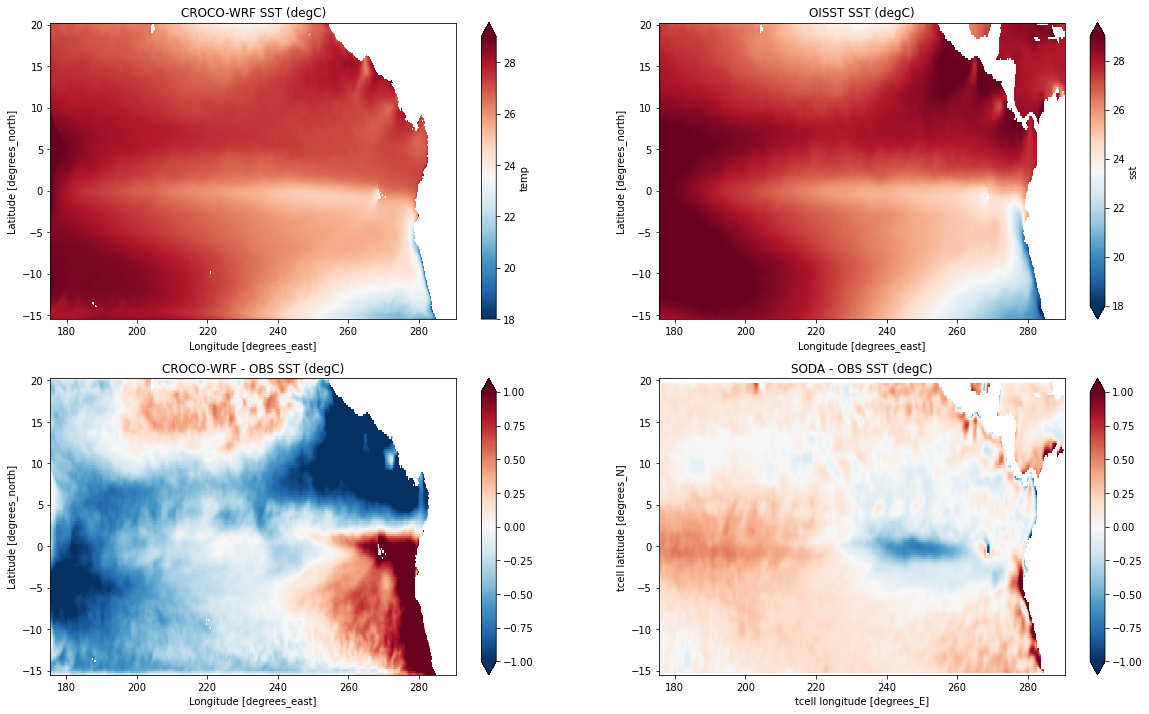

In [11]:
## Annual mean SST:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12))

CROCO_SST.plot(ax=axes[0][0],vmin=18.,vmax=29.,cmap='RdBu_r')
axes[0][0].set_title(sim_name + ' SST (degC)')

OBS_SST.plot(ax=axes[0][1],vmin=18.,vmax=29.,cmap='RdBu_r')
axes[0][1].set_title('OISST SST (degC)')

(CROCO_SST_INT-OBS_SST).plot(ax=axes[1][0],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[1][0].set_title(sim_name + ' - OBS SST (degC)')

(SODA_SST_INT-OBS_SST).plot(ax=axes[1][1],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[1][1].set_title('SODA - OBS SST (degC)')

plt.savefig('Annual_Mean_CROCO-WRF_2014_SST_Bias.png',dpi=100)

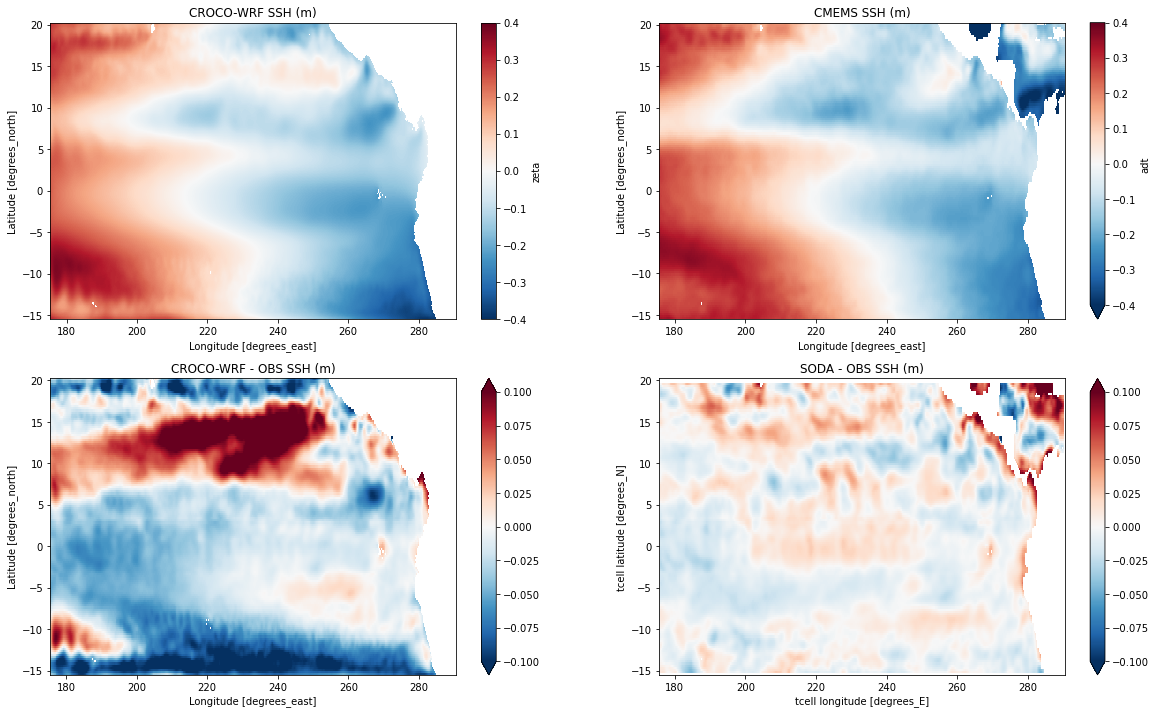

In [12]:
## Annual mean SSH:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12))

CROCO_SSH.plot(ax=axes[0][0],vmin=-0.4,vmax=0.4,cmap='RdBu_r')
axes[0][0].set_title(sim_name + ' SSH (m)')

OBS_SSH.plot(ax=axes[0][1],vmin=-0.4,vmax=0.4,cmap='RdBu_r')
axes[0][1].set_title('CMEMS SSH (m)')

(CROCO_SSH_INT-OBS_SSH).plot(ax=axes[1][0],vmin=-0.1,vmax=0.1,cmap='RdBu_r')
axes[1][0].set_title(sim_name + ' - OBS SSH (m)')

(SODA_SSH_INT-OBS_SSH).plot(ax=axes[1][1],vmin=-0.1,vmax=0.1,cmap='RdBu_r')
axes[1][1].set_title('SODA - OBS SSH (m)')

plt.savefig('Annual_Mean_CROCO-WRF_2014_SSH_Bias.png',dpi=100)

## Seasonal cycle of equatorial SST:

In [13]:
# Calculations
OBS_SST = OISST.sst.groupby('time.month').mean('time').sel(y_rho=slice(-5.,5.)).mean('y_rho').rename({'month':'time'})
CROCO_SST = data['mon'].temp.isel(s_rho=-1).sel(y_rho=slice(-5.,5.)).mean('y_rho')
CROCO_SST["time"] = OBS_SST.time
SODA_SST = SODA.temp.isel(st_ocean=0).groupby('time.month').mean('time').sel(y_rho=slice(-5.,5.)).mean('y_rho').rename({'month':'time'})
CROCO_SST_INT = CROCO_SST.interp(x_rho=OBS_SST.x_rho.values)

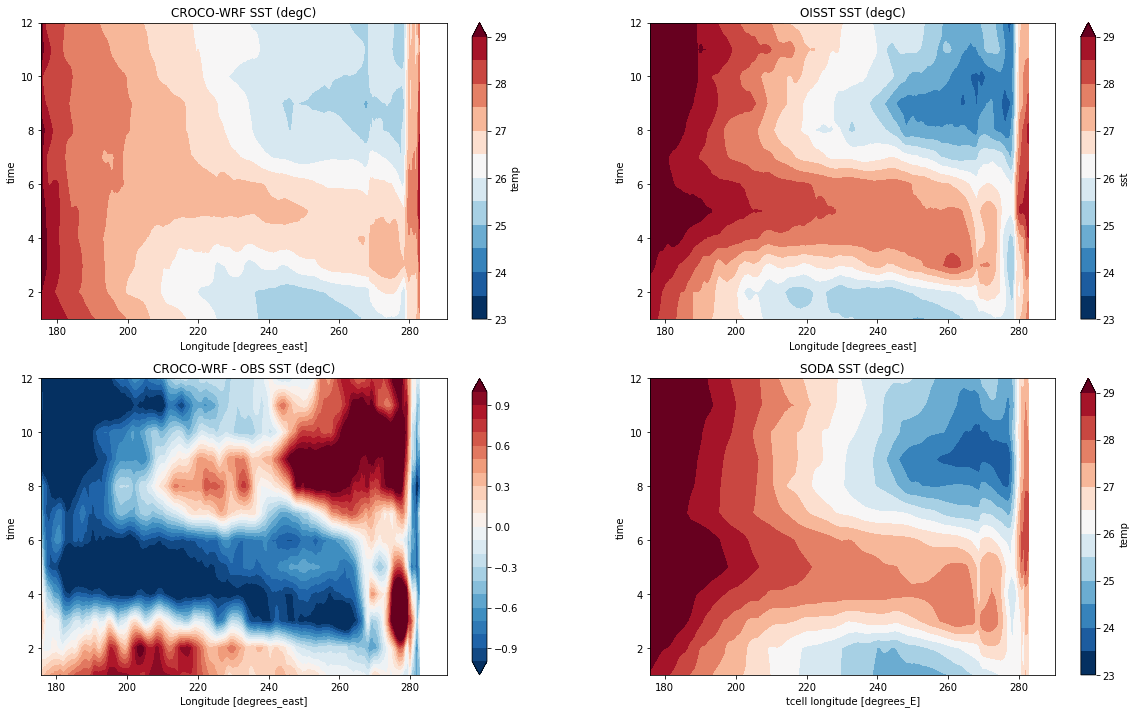

In [14]:
## Seasonal cycle of equatorial SST:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,12))

CROCO_SST.plot.contourf(levels=np.arange(23.,29.5,.5),ax=axes[0][0],cmap='RdBu_r')
axes[0][0].set_title(sim_name + ' SST (degC)')

OBS_SST.plot.contourf(levels=np.arange(23.,29.5,.5),ax=axes[0][1],cmap='RdBu_r')
axes[0][1].set_title('OISST SST (degC)')

(CROCO_SST_INT-OBS_SST).plot.contourf(levels=np.arange(-1.,1.1,.1),ax=axes[1][0],cmap='RdBu_r')
axes[1][0].set_title(sim_name + ' - OBS SST (degC)')

(SODA_SST).plot.contourf(levels=np.arange(23.,29.5,.5),ax=axes[1][1],cmap='RdBu_r')
axes[1][1].set_title('SODA SST (degC)')

plt.savefig('Seasonal_Cycle_CROCO-WRF_2014_Equatorial_SST_Bias.png',dpi=100)

## Longitude surface profiles:

In [15]:
LON = 220.
LON_OM2 = -140.

# Calculations
OBS_SST = OISST.sel(x_rho=LON,method='nearest').sst.mean('time').load()
OBS_SSH = CMEMS.adt.sel(x_rho=LON,method='nearest').mean('time') - CMEMS.adt.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
OBS_SSH.load()

CROCO_SST = data['mon'].sel(x_rho=LON,method='nearest').temp.isel(s_rho=-1).mean('time').load()
CROCO_SSH = data['mon'].sel(x_rho=LON,method='nearest').zeta.mean('time') - data['mon'].zeta.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
CROCO_SSH.load()

SODA_SST = SODA.temp.sel(x_rho=LON,method='nearest').isel(st_ocean=0).mean('time').load()
SODA_SSH = SODA.ssh.sel(x_rho=LON,method='nearest').mean('time') - SODA.ssh.sel(x_rho=LON,method='nearest').mean('time').mean('y_rho')
SODA_SSH.load()

CROCO_U = data['mon'].u.sel(x_u=LON,method='nearest').isel(s_rho=-1).mean('time').load()
SODA_U = SODA.u.sel(xu_ocean=LON,method='nearest').isel(st_ocean=1).mean('time').load()

In [45]:
# ACCESS-OM2 data:
def find_lonprof(ekey,lon):

    expt = exptdict[ekey]['expt']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    temp_prof = temp.isel(st_ocean=0).sel(yt_ocean=slice(minlat,maxlat))\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load() - 273.15
    temp_prof.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                           start_time=itime,end_time=ftime)
    u_prof = u.isel(st_ocean=0).sel(yu_ocean=slice(minlat,maxlat))\
                        .sel(xu_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load()
    u_prof.attrs['units'] = 'ms-1'
    
    # Extract ssh
    ssh = cc.querying.getvar(expt, 'sea_level',session,frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    ssh_prof = ssh.sel(yt_ocean=slice(minlat,maxlat))\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).mean('time').load()
    ssh_prof = ssh_prof - ssh_prof.mean('yt_ocean')
    
    return temp_prof, u_prof, ssh_prof

In [46]:
OM2_1_T, OM2_1_U, OM2_1_SSH = find_lonprof('1degIAF',LON_OM2)
OM2_025_T, OM2_025_U, OM2_025_SSH = find_lonprof('025degIAF',LON_OM2)

In [47]:
OM2_01_T, OM2_01_U, OM2_01_SSH = find_lonprof('01degIAF',LON_OM2)

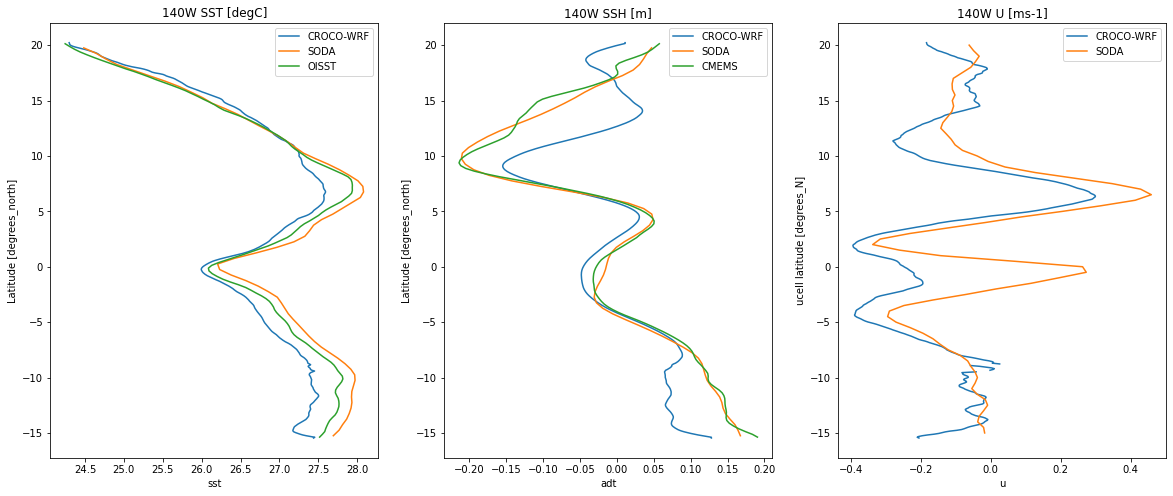

In [16]:
## Latitude line plots:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(20,8))

CROCO_SST.plot(y='y_rho',ax=axes[0],label=sim_name)
SODA_SST.plot(y='y_rho',ax=axes[0],label='SODA')
OBS_SST.plot(y='y_rho',ax=axes[0],label='OISST')

#OM2_1_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2')
#OM2_025_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2-025')
#OM2_01_T.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2-01')
axes[0].set_title('140W SST [degC]')
axes[0].legend()

CROCO_SSH.plot(y='y_rho',ax=axes[1],label=sim_name)
SODA_SSH.plot(y='y_rho',ax=axes[1],label='SODA')
OBS_SSH.plot(y='y_rho',ax=axes[1],label='CMEMS')

#OM2_1_SSH.plot(y='yt_ocean',ax=axes[0],label='ACCESS-OM2')
#OM2_025_SSH.plot(y='yt_ocean',ax=axes[1],label='ACCESS-OM2-025')
#OM2_01_SSH.plot(y='yt_ocean',ax=axes[1],label='ACCESS-OM2-01')
axes[1].set_title('140W SSH [m]')
axes[1].legend()

CROCO_U.plot(y='y_u',ax=axes[2],label=sim_name)
SODA_U.plot(y='yu_ocean',ax=axes[2],label='SODA')

#OM2_1_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2')
#OM2_025_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2-025')
#OM2_01_U.plot(y='yu_ocean',ax=axes[2],label='ACCESS-OM2-01')
axes[2].set_title('140W U [ms-1]')
axes[2].legend()

plt.savefig('Latitude_Profile_CROCO-WRF_140W_SST_SSH_U.png',dpi=100)

## Longitude-depth and latitude-depth profiles of temperature and zonal velocity:

In [17]:
# Region definitions:

depths = (0,300)    # Define depth range for all plots [m]

EqPlons = (175.,275.) # Define longitude range for longitude-depth plot [degrees]
EqPlat = 0.         # Define latitude for longitude-depth plot [degrees]

Ltlon = -140.       # Define longitude for latitude-depth plot [degrees]
ObsLtlon = 220.     # Define longitude for latitude-depth plot for Johnson observations. [degrees]
Ltlats = (-8,10)    # Define latitudes for latitude-depth plot [degrees]

In [18]:
# Johnson observation calculations:

# Define Johnson observations file:
obs_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')

# Extract temperature:
obs_temp = obs_file['POTEMPM']
obs_temp_eq = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_temp_140w = obs_temp.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_obs = obs_temp_140w.YLAT11_101
lon_obs = obs_temp_eq.XLON
dep_obs = obs_temp_eq.ZDEP1_50

# Extract zonal velocity:
obs_u = obs_file['UM']
obs_u_eq = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(YLAT11_101=EqPlat, method='nearest')
obs_u_140w = obs_u.sel(ZDEP1_50=slice(depths[0],depths[1])).sel(XLON=ObsLtlon, method='nearest')
lat_u_obs = obs_u_140w.YLAT11_101
lon_u_obs = obs_u_eq.XLON

In [19]:
# CROCO calculations:
xind = abs(data['mon'].x_rho-220.).argmin().values
yind = abs(data['mon'].y_rho).argmin().values

# 140W depth-lat
u_140w = data['mon'].u.isel(x_u=xind).mean('time').load()
temp_140w = data['mon'].temp.isel(x_rho=xind).mean('time').load()
z_140w = data['mon'].z_rho.isel(x_rho=xind).load()

# Equatorial depth-longitude:
u_eq = data['mon'].u.isel(y_u=yind).mean('time').load()
temp_eq = data['mon'].temp.isel(y_rho=yind).mean('time').load()
z_eq = data['mon'].z_rho.isel(y_rho=yind).load()

In [20]:
# SODA calculations:
SODA_u_140w = SODA.u.sel(xu_ocean=220.,method='nearest').mean('time').load()
SODA_temp_140w = SODA.temp.sel(x_rho=220.,method='nearest').mean('time').load()

SODA_u_eq = SODA.u.sel(yu_ocean=0.,method='nearest').mean('time').load()
SODA_temp_eq = SODA.temp.sel(y_rho=0.,method='nearest').mean('time').load()

TypeError: Number of dimensions of x (2) and y (3) do not match

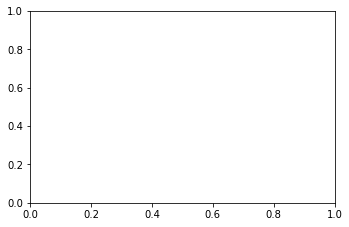

In [21]:
# Define colobar limits and labels:
clevelsT = np.arange(10.,30.,1.)
clevelsU = np.arange(-50,130,10)

fig = plt.figure(figsize=(12,12))

# Plot equatorial slice:
plt.subplot(3,2,1)
xv, yv = np.meshgrid(temp_eq.x_rho,z_eq.isel(x_rho=0))
p1=plt.contourf(xv,z_eq,temp_eq,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_eq,temp_eq,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_eq.x_u,z_eq.isel(x_rho=0))
p2=plt.contour(xv,z_eq.isel(x_rho=slice(0,-1)),100*u_eq,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(EqPlons)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title(sim_name + exp + ' Equatorial Slice')

# Plot latitude-depth slice:
plt.subplot(3,2,2)
xv, yv = np.meshgrid(temp_140w.y_rho,z_140w.isel(y_rho=0))
p3=plt.contourf(xv,z_140w,temp_140w,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,z_140w,temp_140w,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(u_140w.y_u,z_140w.isel(y_rho=0))
p4=plt.contour(xv,z_140w,100*u_140w,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([-300.,0.])
plt.xlim(Ltlats)
#plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('')
plt.title(sim_name + exp + ' 140W slice')

# Plot equatorial slice:
plt.subplot(3,2,3)
xv, yv = np.meshgrid(SODA_temp_eq.x_rho,SODA.st_ocean)
p1=plt.contourf(xv,yv,SODA_temp_eq,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,yv,SODA_temp_eq,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(SODA_u_eq.xu_ocean,SODA.st_ocean)
p2=plt.contour(xv,yv,100*SODA_u_eq,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(EqPlons)
plt.xlabel('')
plt.ylabel('Depth (m)')
plt.title('SODA Equatorial Slice')

# Plot latitude-depth slice:
plt.subplot(3,2,4)
xv, yv = np.meshgrid(SODA_temp_140w.y_rho,SODA.st_ocean)
p3=plt.contourf(xv,yv,SODA_temp_140w,cmap=cm.cm.thermal, 
                               levels=clevelsT,
                               add_colorbar=False, extend='both')
plt.contour(xv,yv,SODA_temp_140w,levels=clevelsT,colors='k',linewidths=0.5)
xv, yv = np.meshgrid(SODA_u_140w.yu_ocean,SODA.st_ocean)
p4=plt.contour(xv,yv,100*SODA_u_140w,colors='w',levels=clevelsU,linewidths=1)
plt.clabel(p4, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.xlim(Ltlats)
plt.gca().invert_yaxis()
plt.xlabel('')
plt.ylabel('')
plt.title('SODA 140W slice')

# Plot observational equatorial slice:
plt.subplot(3,2,5)
p1 = plt.contourf(lon_obs, dep_obs, obs_temp_eq, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lon_obs, dep_obs, obs_temp_eq, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lon_u_obs, dep_obs, obs_u_eq*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(EqPlons)
plt.xlabel('Longitude')
plt.ylabel('Depth (m)')
plt.title('Observations (Johnson)')

# Plot observational latitude-depth slice:
plt.subplot(3,2,6)
p1 = plt.contourf(lat_obs, dep_obs, obs_temp_140w, cmap=cm.cm.thermal, levels=clevelsT, extend='both')
plt.contour(lat_obs, dep_obs, obs_temp_140w, colors='k', levels=clevelsT,linewidths=0.5)
p2 = plt.contour(lat_u_obs, dep_obs, obs_u_140w*100, colors = 'w', linewidths=1,levels=clevelsU)
plt.clabel(p2, fmt='%2.0f', colors='black', fontsize=10)
plt.ylim([0.,300.])
plt.gca().invert_yaxis()
plt.xlim(Ltlats)
plt.xlabel('Latitude')
plt.ylabel('')
plt.title('Observations (Johnson)')

# Add colorbar:
ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical', extend='both')
cb.ax.set_ylabel('Temperature (°C)')
fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])
plt.savefig('CROCO-WRF_PAC12_75_cpl_SODA_Johnson_Comparison.png',dpi=150)

## Vertical profiles at a given location (Annual Mean and TAO-matched times)

In [ ]:
# Calculations:
LON = 220.
lonTAO = '140w'
LAT = 0.
depths = (0.,300.)

CROCO_U = data['mon'].u.sel(x_u=LON,method='nearest').sel(y_u=LAT,method='nearest')
CROCO_T = data['mon'].temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest')
CROCO_Z = data['mon'].z_rho.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest').load()

SODA_U = SODA.u.sel(xu_ocean=LON,method='nearest').sel(yu_ocean=LAT,method='nearest')
SODA_T = SODA.temp.sel(x_rho=LON,method='nearest').sel(y_rho=LAT,method='nearest')
SODA_Z = -SODA.st_ocean

In [ ]:
# TAO and Johnson data extraction function:
obs_th = 2500 # This criteria denotes the minimum number of observations at a given depth required to include this point in the comparison.
def get_TAO(lonTAO):
    # Load temperature:
    tao_file_temp = xr.open_dataset('/g/data/ik11/observations/TAO/test/t0n' + lonTAO + '_dy.cdf')
    tao_temp = tao_file_temp['T_20'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))
    tao_temp = tao_temp.where(tao_temp!=1.e35)
    count = np.count_nonzero(~np.isnan(tao_temp), axis=0)
    tao_temp = tao_temp.isel(depth=count>=obs_th) # Only average if more than x observations at given depth
    
    # Load zonal velocity from ADCP data:
    tao_file_u = xr.open_dataset('/g/data/ik11/observations/TAO/test/adcp0n' + lonTAO + '_dy.cdf')
    tao_u = tao_file_u['u_1205'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_u = tao_u.where(abs(tao_u)<=100.)
    count = np.count_nonzero(~np.isnan(tao_u), axis=0)
    tao_u = tao_u.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth

    # Load zonal velocity from current data:
    tao_file_uc = xr.open_dataset('/g/data/ik11/observations/TAO/cur0n' + lonTAO + '_dy.cdf')
    tao_uc = tao_file_uc['U_320'].isel(lon=0).isel(lat=0).sel(depth=slice(0,400))/100.
    tao_uc = tao_uc.where(abs(tao_uc)<=100.)
    count = np.count_nonzero(~np.isnan(tao_uc), axis=0)
    tao_uc = tao_uc.isel(depth=count>=obs_th)  # Only average if more than x observations at given depth
    
    return tao_temp, tao_u, tao_uc

# Johnson data function:
def get_Joh(lonJoh):
    joh_file = xr.open_dataset('/g/data/ik11/observations/Johnson2002/meanfit_m.cdf')
    joh_temp = joh_file['POTEMPM']
    joh_u = joh_file['UM']

    joh_temp_eq = joh_temp.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    joh_u_eq = joh_u.sel(ZDEP1_50=slice(0,400)).sel(YLAT11_101=0., method='nearest').sel(XLON=lonJoh,method='nearest')
    dep_joh = joh_temp_eq.ZDEP1_50
    
    return joh_temp_eq, joh_u_eq, dep_joh

In [68]:
# ACCESS-OM2 data:
def find_Eqpt(ekey,lon):

    expt = exptdict[ekey]['expt']
    itime = exptdict[ekey]['itime']
    ftime = exptdict[ekey]['ftime']
    
    # Extract temperature
    temp = cc.querying.getvar(expt, 'temp',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                             start_time=itime,end_time=ftime)
    temp_eq = temp.sel(st_ocean=slice(depths[0],depths[1])).sel(yt_ocean=0., method='nearest')\
                        .sel(xt_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).load() - 273.15
    temp_eq.attrs['units'] = 'degrees Celsius'
    
    # Extract velocity
    u = cc.querying.getvar(expt, 'u',session,
                          chunks={'st_ocean': None},frequency='1 monthly',
                           start_time=itime,end_time=ftime)
    u_eq = u.sel(st_ocean=slice(depths[0],depths[1])).sel(yu_ocean=0., method='nearest')\
                        .sel(xu_ocean=lon, method='nearest').sel(time=slice('2014-01-01','2014-12-31')).load()
    u_eq.attrs['units'] = 'cms-1'
    
    return temp_eq, u_eq

In [69]:
OM2_1_T, OM2_1_U = find_Eqpt('1degIAF',-140.)
OM2_025_T, OM2_025_U = find_Eqpt('025degIAF',-140.)

In [70]:
OM2_01_T, OM2_01_U = find_Eqpt('01degIAF',-140.)

In [ ]:
JOH_T, JOH_U, JOH_Z = get_Joh(220.)

In [ ]:
TAO_T, TAO_U, TAO_UC = get_TAO('140w')
TAO_T = TAO_T.sel(time=slice('2014-01-01','2014-12-31'))
TAO_U = TAO_U.sel(time=slice('2014-01-01','2014-12-31'))

In [ ]:
# Full annual mean:
CROCO_U_ALL = CROCO_U.mean('time').load()
CROCO_T_ALL = CROCO_T.mean('time').load()
SODA_U_ALL = SODA_U.mean('time').load()
SODA_T_ALL = SODA_T.mean('time').load()

OM2_1_T_ALL = OM2_1_T.mean('time').load()
OM2_025_T_ALL = OM2_025_T.mean('time').load()
OM2_01_T_ALL = OM2_01_T.mean('time').load()
OM2_1_U_ALL = OM2_1_U.mean('time').load()
OM2_025_U_ALL = OM2_025_U.mean('time').load()
OM2_01_U_ALL = OM2_01_U.mean('time').load()

In [ ]:
# TAO Matched times:
u_surf = TAO_U.isel(depth=0)*0
t_surf = TAO_T.isel(depth=0)*0+1.
u_surf.plot(label='U')
t_surf.plot(label='T')

dates = '2014-09-30','2014-12-31'

In [ ]:
# Full annual mean:
CROCO_U_TAOm = CROCO_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
CROCO_T_TAOm = CROCO_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
SODA_U_TAOm = SODA_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
SODA_T_TAOm = SODA_T.sel(time=slice(dates[0],dates[1])).mean('time').load()

TAO_T_TAOm = TAO_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
TAO_U_TAOm = TAO_U.sel(time=slice(dates[0],dates[1])).mean('time').load()

OM2_1_T_TAOm = OM2_1_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
OM2_025_T_TAOm = OM2_025_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
OM2_01_T_TAOm = OM2_01_T.sel(time=slice(dates[0],dates[1])).mean('time').load()
OM2_1_U_TAOm = OM2_1_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
OM2_025_U_TAOm = OM2_025_U.sel(time=slice(dates[0],dates[1])).mean('time').load()
OM2_01_U_TAOm = OM2_01_U.sel(time=slice(dates[0],dates[1])).mean('time').load()

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(CROCO_U_TAOm,CROCO_Z,linewidth=3,label=sim_name + ' Oct-Dec')
plt.plot(SODA_U_TAOm,SODA_Z,linewidth=3,label='SODA Oct-Dec')
plt.plot(TAO_U_TAOm,-TAO_U.depth,linewidth=3,label='TAO Oct-Dec')
#plt.plot(OM2_1_U_TAOm,-OM2_1_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2 Oct-Dec')
#plt.plot(OM2_025_U_TAOm,-OM2_025_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-025 Oct-Dec')
#plt.plot(OM2_01_U_TAOm,-OM2_01_U_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-01 Oct-Dec')

plt.plot(CROCO_U_ALL,CROCO_Z,linestyle='dashed',label=sim_name + ' ANNUAL')
plt.plot(SODA_U_ALL,SODA_Z,linestyle='dashed',label='SODA ANNUAL')
plt.plot(JOH_U,-JOH_Z,linestyle='dashed',label='Johnson et al')
#plt.plot(OM2_1_U_ALL,-OM2_1_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2 ANNUAL')
#plt.plot(OM2_025_U_ALL,-OM2_025_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-025 ANNUAL')
#plt.plot(OM2_01_U_ALL,-OM2_01_U_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-01 ANNUAL')

plt.ylim([-300.,0.])
plt.legend()
plt.title('Zonal Velocity at 140W, 0N')

plt.subplot(1,2,2)
plt.plot(CROCO_T_TAOm,CROCO_Z,linewidth=3,label=sim_name + ' Oct-Dec')
plt.plot(SODA_T_TAOm,SODA_Z,linewidth=3,label='SODA Oct-Dec')
plt.plot(TAO_T_TAOm,-TAO_T.depth,linewidth=3,label='TAO Oct-Dec')
#plt.plot(OM2_1_T_TAOm,-OM2_1_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2 Oct-Dec')
#plt.plot(OM2_025_T_TAOm,-OM2_025_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-025 Oct-Dec')
#plt.plot(OM2_01_T_TAOm,-OM2_01_T_TAOm.st_ocean,linewidth=3,label='ACCESS-OM2-01 Oct-Dec')

plt.plot(CROCO_T_ALL,CROCO_Z,linestyle='dashed',label=sim_name + ' ANNUAL')
plt.plot(SODA_T_ALL,SODA_Z,linestyle='dashed',label='SODA ANNUAL')
plt.plot(JOH_T,-JOH_Z,linestyle='dashed',label='Johnson et al')
#plt.plot(OM2_1_T_ALL,-OM2_1_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2 ANNUAL')
#plt.plot(OM2_025_T_ALL,-OM2_025_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-025 ANNUAL')
#plt.plot(OM2_01_T_ALL,-OM2_01_T_ALL.st_ocean,linestyle='dashed',label='ACCESS-OM2-01 ANNUAL')

plt.ylim([-300.,0.])
plt.xlim([10.,30.])
plt.legend()
plt.title('Temperature at 140W, 0N')

plt.savefig('140W_VerticalProfiles_TAO_CROCO-WRF.png',dpi=150)

## Summary from Validation of monthly averages 10/5/2022:

- ???

## TIW SST/SSH variability: Longitude high-pass filtering

In [ ]:
# Get data:
OBS_SST = OISST.sst
OBS_SST_DX = (OISST.x_rho[1]-OISST.x_rho[0]).values
OBS_SSH = CMEMS.sla
OBS_SSH_DX = (CMEMS.x_rho[1]-CMEMS.x_rho[0]).values

CROCO_SST = data['day'].temp_surf
CROCO_SSH = data['day'].zeta
CROCO_DX = (data['day'].x_rho[1]-data['day'].x_rho[0]).values

ln_hp_filt = 12.0

In [ ]:
# Limit data sets for speed:
lats = -2., 10.
lons = 180., 275.
times = '2014-01-01','2014-12-31'

OBS_SST = OBS_SST.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
OBS_SSH = OBS_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
CROCO_SST = CROCO_SST.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))
CROCO_SSH = CROCO_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=slice(lats[0],lats[1])).sel(x_rho=slice(lons[0],lons[1]))

In [ ]:
# Do high-pass filtering:
CROCO_SST_hp = (CROCO_SST-CROCO_SST.rolling(x_rho=int(ln_hp_filt/CROCO_DX),center=True).mean())
CROCO_SST_hp_std = CROCO_SST_hp.std('time')
CROCO_SST_hp_std.load()

In [ ]:
CROCO_SSH_hp = (CROCO_SSH-CROCO_SSH.rolling(x_rho=int(ln_hp_filt/CROCO_DX),center=True).mean())
CROCO_SSH_hp_std = CROCO_SSH_hp.std('time')
CROCO_SSH_hp_std.load()

In [ ]:
# Do high-pass filtering (OBS):
OBS_SST_hp = (OBS_SST-OBS_SST.rolling(x_rho=int(ln_hp_filt/OBS_SST_DX),center=True).mean())
OBS_SST_hp_std = OBS_SST_hp.std('time')
OBS_SST_hp_std.load()

In [ ]:
OBS_SSH_hp = (OBS_SSH-OBS_SSH.rolling(x_rho=int(ln_hp_filt/OBS_SSH_DX),center=True).mean())
OBS_SSH_hp_std = OBS_SSH_hp.std('time')
OBS_SSH_hp_std.load()

In [ ]:
tlims = 0.,1.
zlims = 0.,0.08
tsp = tlims[1]/20.
zsp = zlims[1]/20.

# Do the plotting:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
OBS_SST_hp_std.plot.contourf(ax=axes[0][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
OBS_SSH_hp_std.plot.contourf(ax=axes[0][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
CROCO_SST_hp_std.plot.contourf(ax=axes[1][0],levels=np.arange(tlims[0],tlims[1]+tsp,tsp),cmap=cm.cm.amp)
CROCO_SSH_hp_std.plot.contourf(ax=axes[1][1],levels=np.arange(zlims[0],zlims[1]+zsp,zsp),cmap=cm.cm.amp)
    
axes[0][0].set_title('NOAA OISST standard deviation ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH standard deviation (m)')
axes[1][0].set_title(sim_name + ' SST standard deviation ($^\circ$C)')
axes[1][1].set_title(sim_name + ' SSH standard deviation (m)')
axes[0][0].set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
axes[1][0].set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
axes[0][1].set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
axes[1][1].set_xlim([lons[0]+ln_hp_filt/2.,lons[1]-ln_hp_filt/2.])
axes[0][0].grid()
axes[0][1].grid()
axes[1][0].grid()
axes[1][1].grid()
plt.tight_layout()
plt.savefig('PAC12_75_cpl_SSH_SST_FiltPlot_Annual2014.png',dpi=300)

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
reg = -150.,-90.

OBS_SST_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label='OISST')
OBS_SSH_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label='CMEMS')
CROCO_SST_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[0],label='CROCO')
CROCO_SSH_hp_std.sel(x_rho=slice(reg[0]+360.,reg[1]+360.)).mean('x_rho').plot(ax=axes[1],label='CROCO')

for ax in axes:
    for obj in ax.lines:   
        newx = obj.get_ydata()
        newy = obj.get_xdata()

# set new x- and y- data for the line
        obj.set_xdata(newx)
        obj.set_ydata(newy)

axes[0].set_xlim([0.,1.])
axes[0].set_ylim([-2.,10.])
axes[1].set_xlim([0.,0.08])
axes[1].set_ylim([-2.,10.])
axes[0].set_title('150W-90W SST standard deviation ($^\circ$C)')
axes[0].legend()
axes[1].set_title('150W-90W SSH standard deviation m)')
axes[1].legend()

plt.savefig('CROCO_WRF_SSH_SST_FiltPlot_LonAvg.png',dpi=300)

## TIW SST/SSH variability: Hovmoeller

In [ ]:
# Get data:
OBS_SST = OISST.sst
OBS_SST_DX = (OISST.x_rho[1]-OISST.x_rho[0]).values
OBS_SSH = CMEMS.sla
OBS_SSH_DX = (CMEMS.x_rho[1]-CMEMS.x_rho[0]).values

CROCO_SST = data['day'].temp_surf
CROCO_SSH = data['day'].zeta
CROCO_DX = (data['day'].x_rho[1]-data['day'].x_rho[0]).values

ln_hp_filt = 12.0

In [ ]:
# Select range:
lat = 2.
lons = 180., 275.
times = '2014-01-01','2014-12-31'

OBS_SST = OBS_SST.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
OBS_SSH = OBS_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
CROCO_SST = CROCO_SST.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()
CROCO_SSH = CROCO_SSH.sel(time=slice(times[0],times[1])).sel(y_rho=lat,method='nearest').sel(x_rho=slice(lons[0],lons[1])).load()

In [ ]:
CROCO_SSH = CROCO_SSH-CROCO_SSH.mean('time')
OBS_SSH = OBS_SSH-OBS_SSH.mean('time')

In [ ]:
tlims = 20.,28.
zlims = -0.1,0.1
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

OBS_SST.plot(ax=axes[0][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
CROCO_SST.plot(ax=axes[1][0],vmin=tlims[0],vmax=tlims[1],cmap=cm.cm.thermal)
OBS_SSH.plot(ax=axes[0][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.thermal)
CROCO_SSH.plot(ax=axes[1][1],vmin=zlims[0],vmax=zlims[1],cmap=cm.cm.thermal)

axes[0][0].set_title('NOAA OISST ($^\circ$C)')
axes[1][0].set_title(sim_name + ' SST ($^\circ$C)')
axes[0][1].set_title('CMEMS SSH (m)')
axes[1][1].set_title(sim_name + ' SSH (m)')
axes[0][0].grid()
axes[1][0].grid()
axes[0][1].grid()
axes[1][1].grid()
plt.tight_layout()

plt.savefig('CROCO_WRF_SST_SSH_2014_Hovemoeller_2N.png',dpi=150)